## Linear denoiser

In [1]:
USE_TOEPLITZ = True
CHANNEL = 4

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.templates import util as templates_utl
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes
from yass.detect import nnet, nnet_experimental
from yass import preprocess

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model
import seaborn as sns

Using TensorFlow backend.


In [4]:
plt.rcParams['figure.figsize'] = (10, 10)

In [5]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

path_to_detector = '/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/detect_nn2.ckpt'

In [6]:
yass.set_config("../config/gcloud/49/default.yaml", 'noisy')
CONFIG = read_config()

In [8]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)

rec_all = RecordingsReader(path_to_standarized, loader='array').data

# (spatial_sig,
#  temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

rec_all.shape

(6000000, 49)

In [9]:
detector = NeuralNetDetector.load(path_to_detector, 0.5, ch_idx)

(standarized_path,
 standarized_params,
 whiten_filter) = (preprocess
                   .run(if_file_exists='skip'))

(index_clean_arr,
 index_all_arr) = nnet.run(standarized_path, standarized_params, whiten_filter,
                       'overwrite', False,
                        path_to_detector,
                        autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt')

100%|██████████| 4595/4595 [00:45<00:00, 101.95it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


In [10]:
def read_waveforms(rec, idxs, waveform_length, random_shift=False):    
    """Read waveforms from rec using an array of spike times
    """
    _, n_channels = rec.shape

    out = np.empty((len(idxs), waveform_length, n_channels))
    half = int((waveform_length - 1)/2)

    for i, idx in enumerate(idxs):
        offset = -20
    
        if random_shift:
            offset += np.random.randint(-20, 20)

        out[i] = rec[idx-half + offset:idx+half+1 + offset]

    return out


class SpikeIndex:
    
    def __init__(self, spike_index_array, channel_index=None, geometry=None,
                 neighbors=None):
        self.arr = spike_index_array
        self.channel_index = channel_index
        self.geometry = geometry
        self.neighbors = neighbors
    
    def get_times_from_channel(self, channel):
        return self.arr[self.arr[:, 1] == channel][:, 0]
    
    @property
    def shape(self):
        return self.arr.shape
    
    @property
    def n_unique_channels(self):
        return len(np.unique(self.arr[:, 1]))
    
    def read_waveforms_from_channel(self, rec, channel, waveform_length=51, random_shift=True,
                                    only_neighbors=True):
        """Read waveforms from rec using an array of spike times
        """
        _, n_channels = rec.shape
    
        idxs = self.get_times_from_channel(channel)
    
        out = np.empty((len(idxs), waveform_length, n_channels))
        half = int((waveform_length - 1)/2)
    
        for i, idx in enumerate(idxs):
            offset = -20
        
            if random_shift:
                offset += np.random.randint(-20, 20)

            out[i] = rec[idx-half + offset:idx+half+1 + offset]
        
        if only_neighbors:
            tp = TemplatesProcessor(out)
            out = tp.crop_spatially(self.neighbors, self.geometry, inplace=False).values

        return out

index_all = SpikeIndex(index_all_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)
index_clean = SpikeIndex(index_clean_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)

In [11]:
index_all.shape, index_all.n_unique_channels, index_clean.shape, index_clean.n_unique_channels

((716851, 2), 49, (80022, 2), 49)

In [12]:
def kill_signal_from_index(recordings, spike_index, window_size):
    """
    """
    recordings = np.copy(recordings)

    T, C = recordings.shape
    R = int((window_size-1)/2)

    # this will hold a flag 1 (noise), 0 (signal) for every obseration in the
    # recordings
    is_noise_idx = np.zeros((T, C))

    # go through every neighboring channel
    for c in range(C):

        # get indexes whose main channel is c
        idx_temp = spike_index[spike_index[:, 1] == c]

        # shift every index found
        for j in range(-R, R+1):

            # shift
            idx_temp2 = idx_temp + j

            # remove indexes outside range [0, T]
            idx_temp2 = idx_temp2[np.logical_and(idx_temp2 >= 0,
                                                 idx_temp2 < T)]

            # set surviving indexes to nan
            recordings[idx_temp2, c] = np.nan

        is_signal_idx_temp = np.isnan(recordings[:, c])

        # standarize data, ignoring nans
#         recordings[:, c] = recordings[:, c]/np.nanstd(recordings[:, c])

        # set non noise indexes to 0 in the recordings
        recordings[is_signal_idx_temp, c] = 0

        # save noise indexes
        is_noise_idx[~is_signal_idx_temp, c] = 1

    return recordings, is_noise_idx

In [16]:
rec_with_nas, is_noise_idx = kill_signal_from_index(rec_all, index_all.arr, 61)

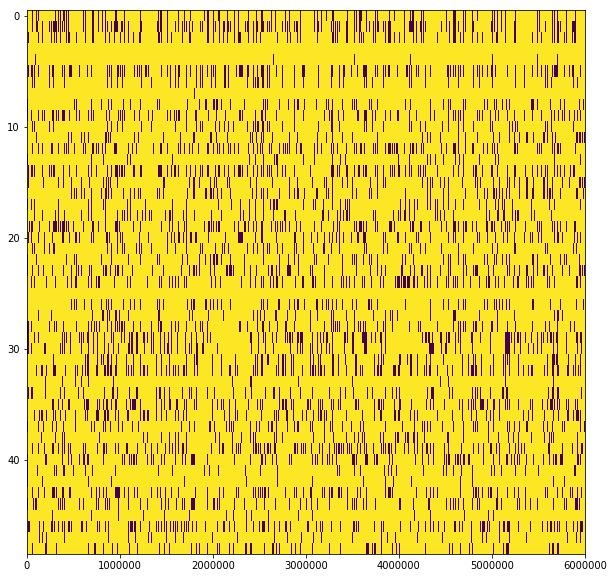

In [17]:
plt.imshow(is_noise_idx.T, aspect='auto')

In [18]:
noise_samples = noise_utils.search_noise_snippets(rec_with_nas, is_noise_idx, sample_size=20000,
                                          temporal_size=51, channel_choices=CONFIG.channel_index[[0], :7],
                                          max_trials_per_sample=1000,
                                          allow_smaller_sample_size=False)
noise_samples.shape

(20000, 51, 7)

In [19]:
def sample(rec, waveform_length, n):
    """Sample n waveforms of length waveform_length from recordings
    """
    min_idx = 0
    max_idx = rec.shape[0] - waveform_length

    idxs = np.random.randint(min_idx, max_idx, n)

    samples = np.empty((n, waveform_length, rec.shape[1]))

    for i, idx in enumerate(idxs):
        samples[i] = rec[i:i+waveform_length, :]
    
    return samples


def sample_noise(rec, waveform_length, n, detector, max_amplitude):
    """
    Sample n noise snippets of length waveform_length from recordings, pass them through a detector
    and remove the ones with > amplitude than max_amplitude
    """
    noise = np.empty((n, waveform_length, rec.shape[1]))
    remaining = n
    
    while remaining > 0:
        wfs = sample(rec, waveform_length, n)

        noise_detector_idx = ~ detector.predict(wfs).astype(bool)
        noise_amplitude_idx = augment_util.amplitudes(wfs) <= max_amplitude
        noise_idx = noise_detector_idx & noise_amplitude_idx

        noise_found = noise_idx.sum()

        idx_start = n - remaining
        idx_end = idx_start + noise_found
                
        if idx_end > n:
            idx_end = n

        noise[idx_start:idx_end] = wfs[noise_idx][:idx_end-idx_start, :]
        
        remaining -= noise_found
    
    return noise

In [20]:
# get noise samples from first channel neighbors
rec = rec_all[:, ch_idx[0]]
noise_samples = sample_noise(rec, 51, 20000, detector, 4)

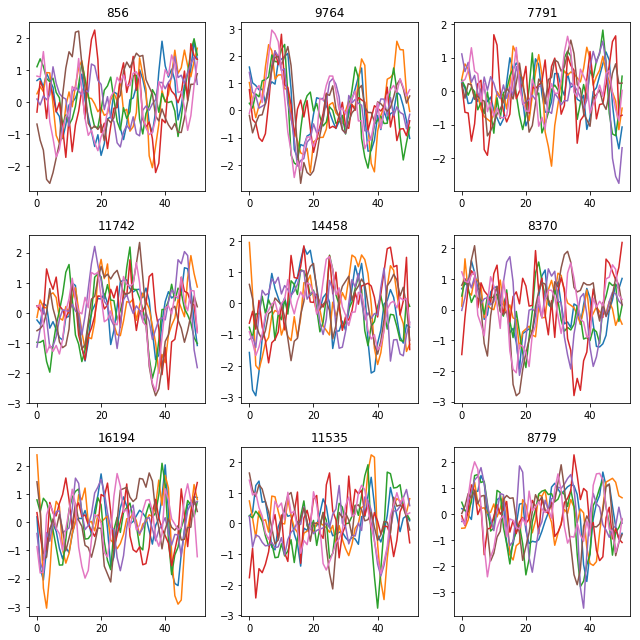

In [21]:
plot.grid_from_array(noise_samples, axis=0, elements=9, auto_figsize=3)

In [22]:
from sklearn.covariance import EmpiricalCovariance, LedoitWolf

In [23]:
noise_cov = (LedoitWolf(store_precision=False, assume_centered=False)
             .fit(noise_samples.reshape(noise_samples.shape[0], -1))).covariance_

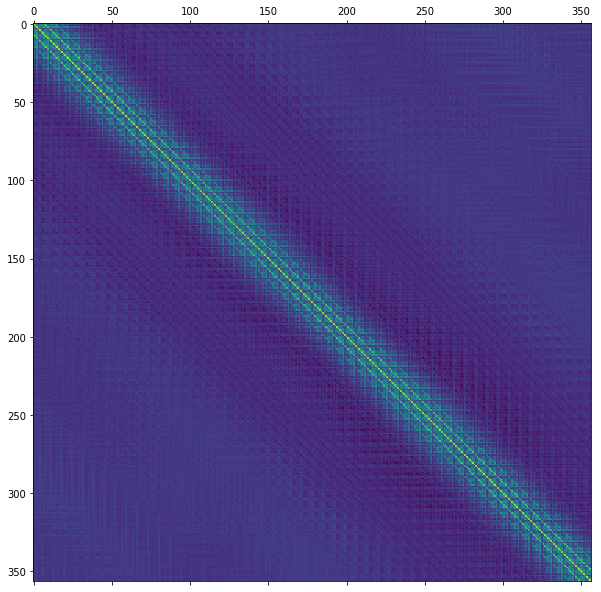

In [24]:
plt.matshow(noise_cov)

In [25]:
spikes = index_all.read_waveforms_from_channel(rec_all, channel=CHANNEL, random_shift=False,
                                               only_neighbors=True)

In [26]:
# spikes = read_waveforms(rec_all, index_all.get_times_from_channel(1), 51, random_shift=False)
spikes.shape

(2132, 51, 7)

In [27]:
# sns.distplot(np.argmax(np.max(spikes, axis=1), axis=1))

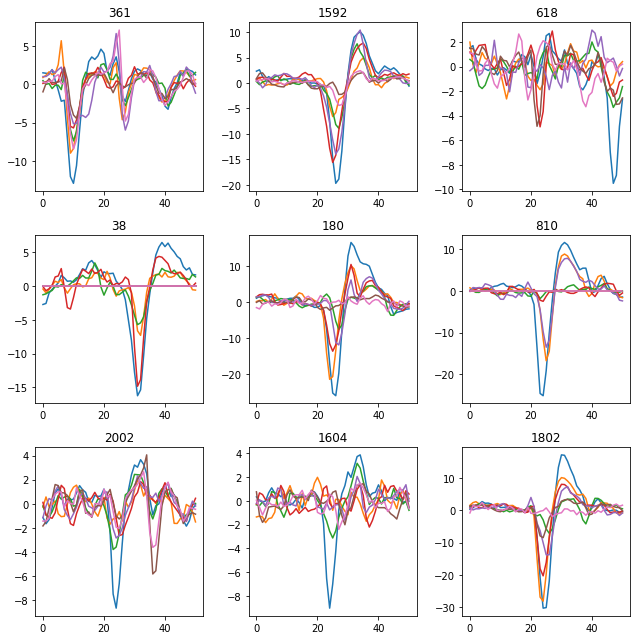

In [28]:
plot.grid_from_array(spikes, axis=0, elements=9, auto_figsize=3)

In [29]:
spikes_cov = (LedoitWolf(store_precision=False, assume_centered=True)
                    .fit(spikes.reshape(spikes.shape[0], -1))).covariance_

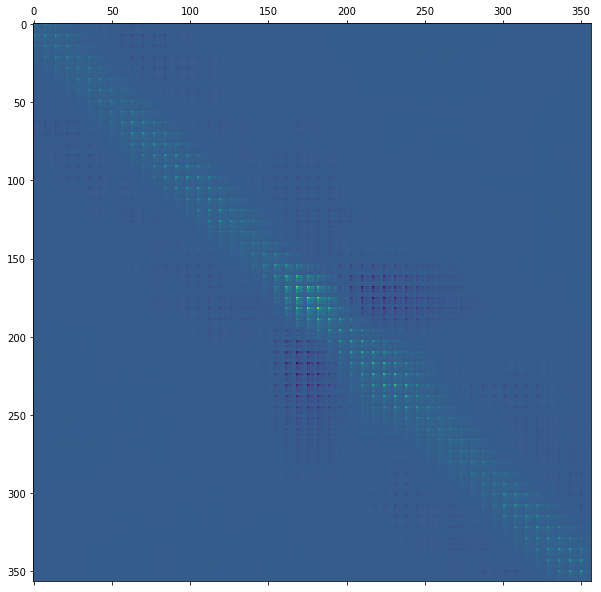

In [30]:
plt.matshow(spikes_cov)

In [31]:
cx = spikes_cov - noise_cov

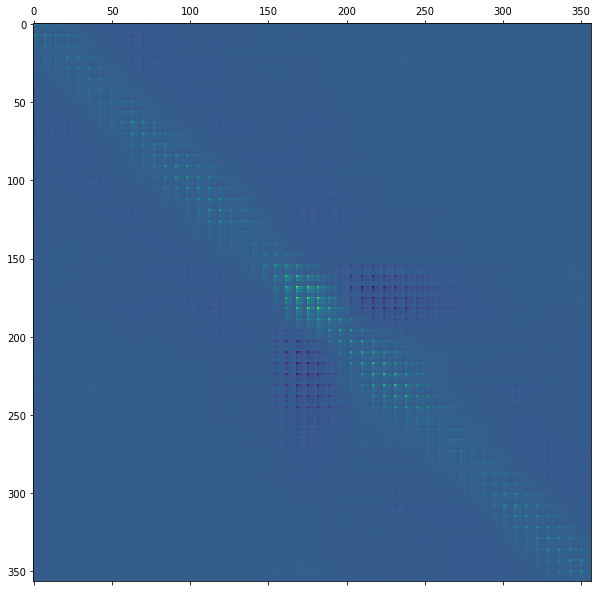

In [32]:
plt.matshow(cx)

In [33]:
mapping = np.matmul(np.linalg.inv(spikes_cov), cx)

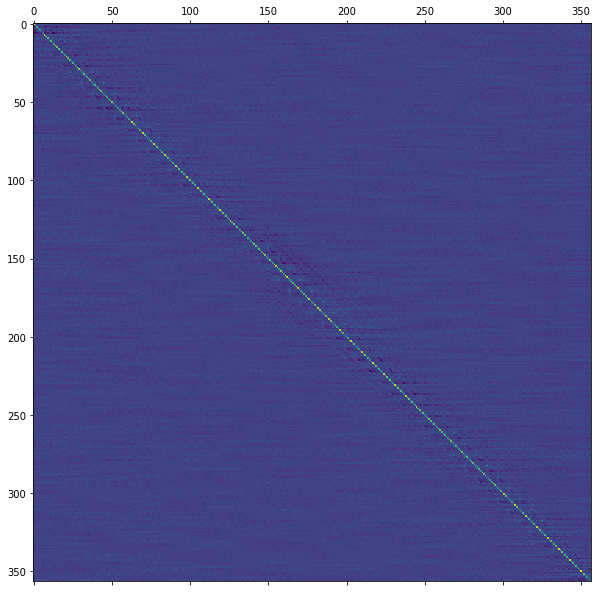

In [34]:
plt.matshow(mapping)

In [35]:
from itertools import product

def make_toeplitz(m):
    """Takes the average of diagonals
    """
    n_diagonals = m.shape[0] - 1

    for i in range(n_diagonals):
        diag = m.diagonal(i)
        val = diag.mean()
        np.fill_diagonal(m[:, i:], val)

    for i in range(1, n_diagonals):
        diag = m.diagonal(-i)
        val = diag.mean()
        np.fill_diagonal(m[i:], val)


def slice_transformation(matrix, fn, offset=51):
    matrix = matrix.copy()
    
    n_windows = int(matrix.shape[0] / offset)

    slices = [slice(i * offset, (i+1) * offset)  for i in range(n_windows)]
    p = product(slices, slices)

    for i, j in p:
        m = matrix[i, j]
        make_toeplitz(m)
    
    return matrix

In [36]:
mapping_toeplitz = slice_transformation(mapping, make_toeplitz)

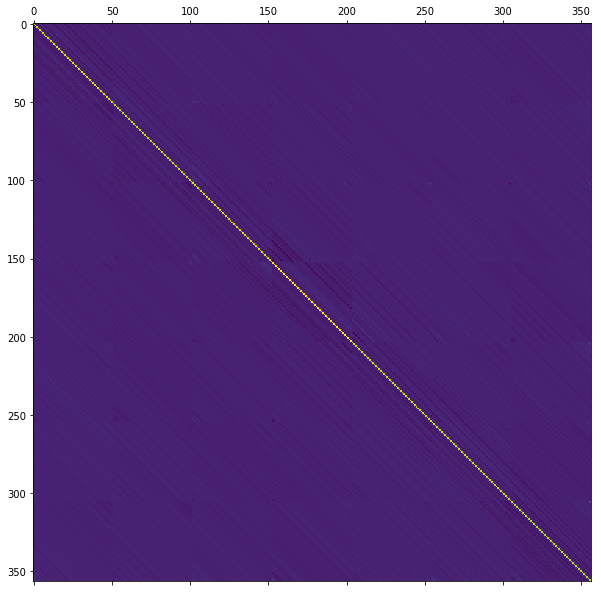

In [37]:
plt.matshow(mapping_toeplitz)

In [86]:
if USE_TOEPLITZ:
    denoiser = mapping_toeplitz
else:
    denoiser = mapping

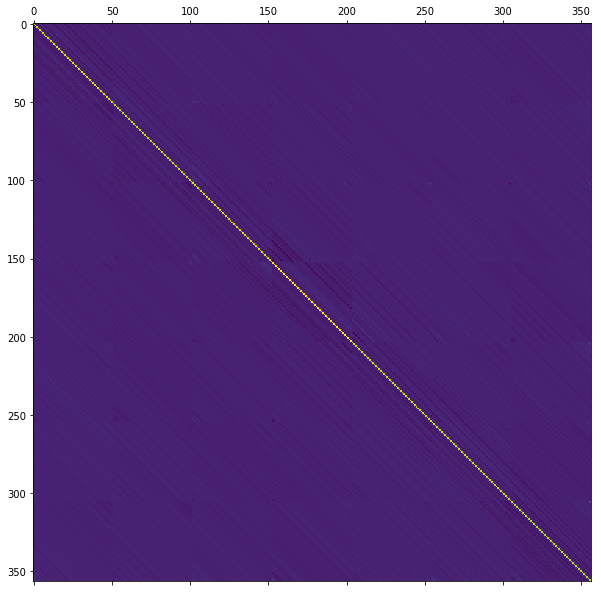

In [87]:
plt.matshow(denoiser)

In [88]:
denoised = np.matmul(spikes.reshape(spikes.shape[0], -1), denoiser).reshape(-1, 51, 7)

In [89]:
idxs = np.argsort(templates_utl.ptps(denoised))

denoised = denoised[idxs]
spikes = spikes[idxs]

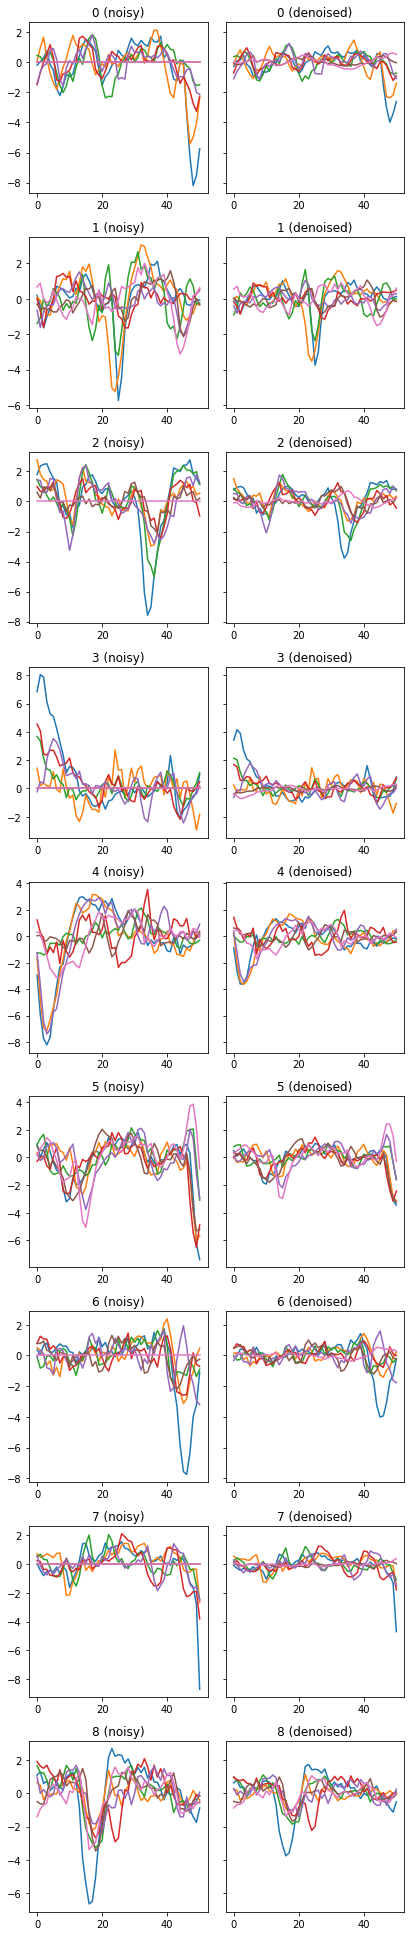

In [90]:
plot.grid_from_array([spikes, denoised], axis=0, elements=range(9),
                     auto_figsize=3, sharey='row', group_names=['noisy', 'denoised'])

## Denoise recordings chunkwise

In [91]:
def create_chunks(recordings, n_chunks, window_size, offset):
    chunks_all = []
    
    n_observations, n_channels = recordings.shape

    for i in range(n_chunks):
        start = i * offset
        end = i * offset + window_size
        
        if end > n_observations:
            end = n_observations

            if end - start == window_size:
                chunk = recordings[start:end, :]
                chunks_all.append(chunk)

            break
        else:
            chunk = recordings[start:end, :]
            chunks_all.append(chunk)
    
    return np.stack(chunks_all)

def denoise_chunks(chunks, mapping):
    denoised = np.matmul(chunks.reshape(chunks.shape[0], -1), mapping).reshape(-1, 51, 7)
    return denoised

def unroll_chunks(chunks):
    return chunks.reshape(-1, 7)

In [92]:
n_chunks = 200000
max_idx = n_chunks * 51


chunks = create_chunks(rec_all[:, ch_idx[CHANNEL]], n_chunks, 51, 51)
denoised = denoise_chunks(chunks, denoiser)
denoised_rec = unroll_chunks(denoised)

In [93]:
from yass.preprocess.batch import standarize

stds = standarize._standard_deviation(denoised_rec, CONFIG.recordings.sampling_rate)
denoised_rec = np.divide(denoised_rec, stds)

In [94]:
denoised_rec.shape

(5999997, 7)

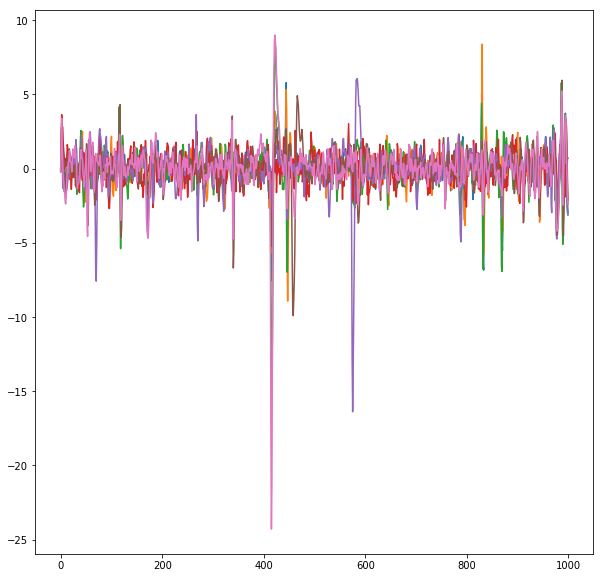

In [95]:
_ = plt.plot(rec[:1000, :])

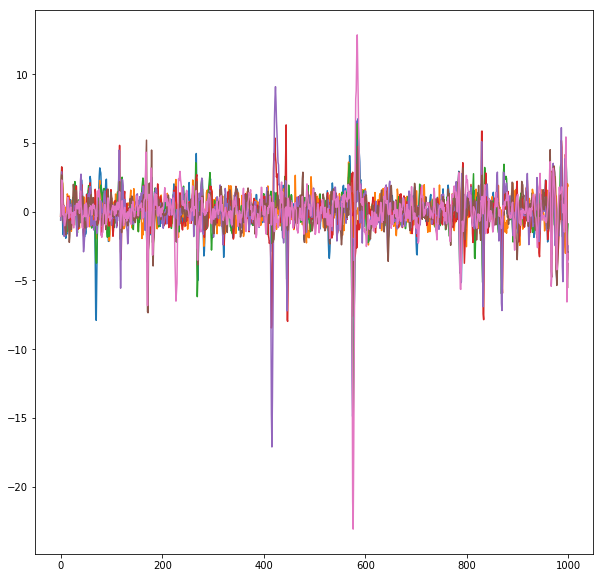

In [96]:
_ = plt.plot(denoised_rec[:1000, :])

## Compare distribution

In [97]:
standarized_path_denoised = '/tmp/denoised.bin'
denoised_rec.tofile(standarized_path_denoised)
standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}

yass.set_config("../config/gcloud/49/default.yaml", 'denoised')
CONFIG = read_config()

In [98]:
rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
                            standarized_params_denoised['n_channels'],
                            standarized_params_denoised['data_order'],
                            loader='array')
rec_denoised.shape

(5999997, 7)

In [ ]:
(_,#standarized_path,
 _,#standarized_params,
 whiten_filter) = (preprocess
                   .run(if_file_exists='skip'))

(index_clean_denoised_arr,
 index_all_denoised_arr) = nnet.run(standarized_path_denoised, standarized_params_denoised, whiten_filter,
                                      'overwrite', False,
                                       path_to_detector,
                                       autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt')

 25%|██▌       | 165/657 [00:03<00:11, 43.47it/s]

In [ ]:
index_clean_denoised = SpikeIndex(index_clean_denoised_arr)
index_all_denoised = SpikeIndex(index_all_denoised_arr)

In [ ]:
index_clean_denoised.shape, index_all_denoised.shape

In [ ]:
# spikes for channel 0 (main channel) in denoised data
index_clean_denoised = index_clean_denoised.get_times_from_channel(0)
index_all_denoised = index_all_denoised.get_times_from_channel(0)

index_clean_denoised.shape, index_all_denoised.shape

In [ ]:
# spikes for channel CHANNEL in the original detection
index_clean_raw = index_clean.get_times_from_channel(CHANNEL)
index_all_raw = index_all.get_times_from_channel(CHANNEL)

index_clean_raw.shape, index_all_raw.shape

In [ ]:
def plot_ptps(rec, spikes, ax=None, waveform_length=51, label=None):
    wfs = read_waveforms(rec, spikes, waveform_length=51)
    ptps = templates_utl.ptps(wfs)
    sns.distplot(ptps, ax=ax, label=label)

plot_ptps(rec, index_clean_raw, label='Raw recordings')
# plot_ptps(rec, index_clean_denoised, label='Raw recordings, denoised spike index')
plot_ptps(rec_denoised, index_clean_denoised, label='Denoised recordings (re-standarized)')

plt.legend()
_ = plt.title('PTP for clean spikes detected in channel {}, Toeplitz enforced: {}'.format(CHANNEL, USE_TOEPLITZ))

In [ ]:
plot_ptps(rec, index_all_raw, label='Raw recordings')
plot_ptps(rec_denoised, index_all_denoised, label='Denoised recordings (re-standarized)')

plt.legend()
_ = plt.title('PTP for all spikes detected in channel {}, Toeplitz enforced: {}'.format(CHANNEL, USE_TOEPLITZ))

In [ ]:
new = set(index_all_denoised) - set(index_all_raw)
missing = set(index_all_raw) - set(index_all_denoised)

In [ ]:
new_wfs_noisy = read_waveforms(rec, new, waveform_length=51)
new_wfs_denoised = read_waveforms(rec_denoised, new, waveform_length=51)

idxs = np.argsort(templates_utl.ptps(new_wfs_noisy))
new_wfs_noisy = new_wfs_noisy[idxs]
new_wfs_denoised = new_wfs_denoised[idxs]

plot.grid_from_array([new_wfs_noisy, new_wfs_denoised], axis=0,
                     elements=range(9), auto_figsize=3,
                     group_names=['noisy', 'denoised'])

In [ ]:
detector.predict(new_wfs_noisy).sum(), detector.predict(new_wfs_denoised).sum()

In [ ]:
missing_wfs_noisy = read_waveforms(rec, missing, waveform_length=51)
missing_wfs_denoised = read_waveforms(rec_denoised, missing, waveform_length=51)

idxs = np.argsort(templates_utl.ptps(missing_wfs_noisy))

missing_wfs_noisy = missing_wfs_noisy[idxs]
missing_wfs_denoised = missing_wfs_denoised[idxs]

plot.grid_from_array([missing_wfs_noisy, missing_wfs_denoised], axis=0,
                     elements=range(9), auto_figsize=3,
                     group_names=['noisy', 'denoised'])

In [ ]:
detector.predict(missing_wfs_noisy).sum(), detector.predict(missing_wfs_denoised).sum()